In [1]:
import pandas as pd
import numpy as np
import statistics
import scipy.stats
from sklearn.datasets import fetch_openml
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '..\\CountsOutlierDetector')
from counts_outlier_detector import CountsOutlierDetector

sys.path.insert(0, '..\\..\\Doping_project')
from outliers_test import DopingOutliersTest

In [2]:
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_rows = 1000
pd.options.display.width = 10000

In [3]:
real_files = [
    'MiceProtein',         
    'audiology',
    'car',
    'autoUniv-au7-500',
    'jungle_chess_2pcs_raw_endgame_complete',
    'arrhythmia',
    'Australian',
    'haberman',
    'heart-statlog',
    'ionosphere',
    'sonar',
    'vote',
    'hepatitis',
    'collins',
    'lymph',
    'trains',
    'socmob',
    'colic',
    'rabe_266',
    'ecoli',
    'heart-h',
    'spectrometer',
    'analcatdata_chlamydia',
    'visualizing_environmental',
    'braziltourism',
    'elevators',
    'chscase_geyser1',
    'hayes-roth',
    'analcatdata_boxing1',
    'servo',
    'fruitfly',
    'sleuth_case2002',
    'grub-damage',
    'veteran',
    'vinnie',
    'pasture',
    'delta_ailerons',
    'white-clover',
    'machine_cpu',
    'kin8nm',
    'prnn_fglass',
    'chscase_census2'
]      

In [4]:
n_bins_arr = [2, 3, 5, 7, 9, 11, 13]
max_dims_arr = [2, 3, 4, 5, 6]
thresholds_arr = [0.01, 0.02, 0.05,  0.1, 0.25]

In [5]:
full_results_dict = {}
overall_results_arr = []

for n_bins in n_bins_arr:
    for max_dim in max_dims_arr:
        for threshold in thresholds_arr:
            print(f"testing n_bins: {n_bins}, max_dim: {max_dim}, threshold: {threshold}")
            scores_arr = []
            process_time_arr = []
            for filename in real_files:
                
                # Load the dataset. Most use version 1, with some exceptions
                version = 1
                if filename in ['numerai28.6', 'car', 'arrhythmia', 'collins']:
                    version = 2 
                if filename in ['MiceProtein', 'Australian', 'hepatitis']:
                    version = 'active'
                data = fetch_openml(filename, version=version)
                df = pd.DataFrame(data.data, columns=data.feature_names)
                
                # Create a doped copy of the dataset
                data_modifier = DopingOutliersTest()
                df_modified, outlier_scores = data_modifier.transform(df, random_state=0, verbose=False)
                if df_modified is None:
                    print(f"Returned None for dataset: {filename}")
                    continue
                    
                st = time.process_time()
                    
                # We hold all other parameters as the default values. This includes max_num_combinations,
                # so in some cases, the detector will not test up to full number of dimensions specified.
                det = CountsOutlierDetector(
                    n_bins=n_bins, 
                    max_dimensions=max_dim, 
                    threshold=threshold,
                    verbose=False)
                results = det.predict(df)
                y_orig_cod = results['Scores']
                    
                det = CountsOutlierDetector(
                    n_bins=n_bins, 
                    max_dimensions=max_dim, 
                    threshold=threshold,
                    verbose=False)
                results = det.predict(df_modified)
                y_modified_cod = results['Scores']            
                
                et = time.process_time()                
                y_gain = y_modified_cod - y_orig_cod
                
                if y_gain.max() > 0.0:
                    spearman_corr = scipy.stats.spearmanr(y_gain, outlier_scores)[0]                
                else:
                    spearman_corr = 0.0
                scores_arr.append(spearman_corr)            
                process_time_arr.append(et - st)
                
                if filename in full_results_dict:
                    full_results_dict[filename].append(spearman_corr)
                else:
                    full_results_dict[filename] = [spearman_corr]
            
            avg_score = statistics.mean(scores_arr)
            avg_time = statistics.mean(process_time_arr)
            result = [n_bins, max_dim, threshold, avg_score, avg_time]
            overall_results_arr.append(result)
            print("  Average score: ", avg_score)
            print("  Average time:  ", avg_time)

overall_results_df = pd.DataFrame(
    overall_results_arr, 
    columns=['n_bins', 'max_dims', 'threshold', 'Avg Score', 'Avg Time'])

testing n_bins: 2, max_dim: 2, threshold: 0.01
  Average score:  0.22466150185501635
  Average time:   0.14546130952380953
testing n_bins: 2, max_dim: 2, threshold: 0.02
  Average score:  0.382019065045433
  Average time:   0.14211309523809523
testing n_bins: 2, max_dim: 2, threshold: 0.05
  Average score:  0.4230619742791543
  Average time:   0.14620535714285715
testing n_bins: 2, max_dim: 2, threshold: 0.1
  Average score:  0.4379329589180726
  Average time:   0.14471726190476192
testing n_bins: 2, max_dim: 2, threshold: 0.25
  Average score:  0.4440918197413726
  Average time:   0.15885416666666666
testing n_bins: 2, max_dim: 3, threshold: 0.01
  Average score:  0.22298752314983442
  Average time:   0.17857142857142858
testing n_bins: 2, max_dim: 3, threshold: 0.02
  Average score:  0.37458570971540206
  Average time:   0.17745535714285715
testing n_bins: 2, max_dim: 3, threshold: 0.05
  Average score:  0.39154292708852984
  Average time:   0.18489583333333334
testing n_bins: 2, max

  Average score:  0.4599608532641733
  Average time:   0.5554315476190477
testing n_bins: 5, max_dim: 5, threshold: 0.25
  Average score:  0.34938781632935795
  Average time:   0.5718005952380952
testing n_bins: 5, max_dim: 6, threshold: 0.01
  Average score:  0.22717547916008246
  Average time:   1.1056547619047619
testing n_bins: 5, max_dim: 6, threshold: 0.02
  Average score:  0.4452316338675302
  Average time:   1.0736607142857142
testing n_bins: 5, max_dim: 6, threshold: 0.05
  Average score:  0.5264045297548938
  Average time:   1.0472470238095237
testing n_bins: 5, max_dim: 6, threshold: 0.1
  Average score:  0.4599608532641733
  Average time:   1.0364583333333333
testing n_bins: 5, max_dim: 6, threshold: 0.25
  Average score:  0.34938781632935795
  Average time:   1.0714285714285714
testing n_bins: 7, max_dim: 2, threshold: 0.01
  Average score:  0.2006372080164762
  Average time:   0.17633928571428573
testing n_bins: 7, max_dim: 2, threshold: 0.02
  Average score:  0.415857863

  Average score:  0.3778112597354255
  Average time:   0.38578869047619047
testing n_bins: 11, max_dim: 4, threshold: 0.05
  Average score:  0.4947641350413726
  Average time:   0.36904761904761907
testing n_bins: 11, max_dim: 4, threshold: 0.1
  Average score:  0.49811236587049096
  Average time:   0.35825892857142855
testing n_bins: 11, max_dim: 4, threshold: 0.25
  Average score:  0.4123769971191575
  Average time:   0.390625
testing n_bins: 11, max_dim: 5, threshold: 0.01
  Average score:  0.1965716947025839
  Average time:   0.4921875
testing n_bins: 11, max_dim: 5, threshold: 0.02
  Average score:  0.3778112597354255
  Average time:   0.4799107142857143
testing n_bins: 11, max_dim: 5, threshold: 0.05
  Average score:  0.4947641350413726
  Average time:   0.43005952380952384
testing n_bins: 11, max_dim: 5, threshold: 0.1
  Average score:  0.49811236587049096
  Average time:   0.4348958333333333
testing n_bins: 11, max_dim: 5, threshold: 0.25
  Average score:  0.4123769971191575
  

In [6]:
overall_results_df = overall_results_df.sort_values('Avg Score')
display(overall_results_df)

,n_bins,max_dims,threshold,Avg Score,Avg Time
165,13,5,0.01,0.178874,0.407738
155,13,3,0.01,0.178874,0.281994
170,13,6,0.01,0.178874,0.803943
150,13,2,0.01,0.178874,0.216518
160,13,4,0.01,0.178874,0.324405
145,11,6,0.01,0.196572,0.857515
140,11,5,0.01,0.196572,0.492188
135,11,4,0.01,0.196572,0.397321
125,11,2,0.01,0.196572,0.196057
130,11,3,0.01,0.196572,0.337426


In [7]:
col_names = []
for n_bins in n_bins_arr:
    for max_dim in max_dims_arr:
        for threshold in thresholds_arr:
            col_names.append(f"nbins:{n_bins} max_dim:{max_dim} threshold:{threshold}")

full_results_df = pd.DataFrame(full_results_dict).T
full_results_df.columns = col_names
full_results_df

,nbins:2 max_dim:2 threshold:0.01,nbins:2 max_dim:2 threshold:0.02,nbins:2 max_dim:2 threshold:0.05,nbins:2 max_dim:2 threshold:0.1,nbins:2 max_dim:2 threshold:0.25,nbins:2 max_dim:3 threshold:0.01,nbins:2 max_dim:3 threshold:0.02,nbins:2 max_dim:3 threshold:0.05,nbins:2 max_dim:3 threshold:0.1,nbins:2 max_dim:3 threshold:0.25,nbins:2 max_dim:4 threshold:0.01,nbins:2 max_dim:4 threshold:0.02,nbins:2 max_dim:4 threshold:0.05,nbins:2 max_dim:4 threshold:0.1,nbins:2 max_dim:4 threshold:0.25,nbins:2 max_dim:5 threshold:0.01,nbins:2 max_dim:5 threshold:0.02,nbins:2 max_dim:5 threshold:0.05,nbins:2 max_dim:5 threshold:0.1,nbins:2 max_dim:5 threshold:0.25,nbins:2 max_dim:6 threshold:0.01,nbins:2 max_dim:6 threshold:0.02,nbins:2 max_dim:6 threshold:0.05,nbins:2 max_dim:6 threshold:0.1,nbins:2 max_dim:6 threshold:0.25,nbins:3 max_dim:2 threshold:0.01,nbins:3 max_dim:2 threshold:0.02,nbins:3 max_dim:2 threshold:0.05,nbins:3 max_dim:2 threshold:0.1,nbins:3 max_dim:2 threshold:0.25,nbins:3 max_dim:3 threshold:0.01,nbins:3 max_dim:3 threshold:0.02,nbins:3 max_dim:3 threshold:0.05,nbins:3 max_dim:3 threshold:0.1,nbins:3 max_dim:3 threshold:0.25,nbins:3 max_dim:4 threshold:0.01,nbins:3 max_dim:4 threshold:0.02,nbins:3 max_dim:4 threshold:0.05,nbins:3 max_dim:4 threshold:0.1,nbins:3 max_dim:4 threshold:0.25,nbins:3 max_dim:5 threshold:0.01,nbins:3 max_dim:5 threshold:0.02,nbins:3 max_dim:5 threshold:0.05,nbins:3 max_dim:5 threshold:0.1,nbins:3 max_dim:5 threshold:0.25,nbins:3 max_dim:6 threshold:0.01,nbins:3 max_dim:6 threshold:0.02,nbins:3 max_dim:6 threshold:0.05,nbins:3 max_dim:6 threshold:0.1,nbins:3 max_dim:6 threshold:0.25,nbins:5 max_dim:2 threshold:0.01,nbins:5 max_dim:2 threshold:0.02,nbins:5 max_dim:2 threshold:0.05,nbins:5 max_dim:2 threshold:0.1,nbins:5 max_dim:2 threshold:0.25,nbins:5 max_dim:3 threshold:0.01,nbins:5 max_dim:3 threshold:0.02,nbins:5 max_dim:3 threshold:0.05,nbins:5 max_dim:3 threshold:0.1,nbins:5 max_dim:3 threshold:0.25,nbins:5 max_dim:4 threshold:0.01,nbins:5 max_dim:4 threshold:0.02,nbins:5 max_dim:4 threshold:0.05,nbins:5 max_dim:4 threshold:0.1,nbins:5 max_dim:4 threshold:0.25,nbins:5 max_dim:5 threshold:0.01,nbins:5 max_dim:5 threshold:0.02,nbins:5 max_dim:5 threshold:0.05,nbins:5 max_dim:5 threshold:0.1,nbins:5 max_dim:5 threshold:0.25,nbins:5 max_dim:6 threshold:0.01,nbins:5 max_dim:6 threshold:0.02,nbins:5 max_dim:6 threshold:0.05,nbins:5 max_dim:6 threshold:0.1,nbins:5 max_dim:6 threshold:0.25,nbins:7 max_dim:2 threshold:0.01,nbins:7 max_dim:2 threshold:0.02,nbins:7 max_dim:2 threshold:0.05,nbins:7 max_dim:2 threshold:0.1,nbins:7 max_dim:2 threshold:0.25,nbins:7 max_dim:3 threshold:0.01,nbins:7 max_dim:3 threshold:0.02,nbins:7 max_dim:3 threshold:0.05,nbins:7 max_dim:3 threshold:0.1,nbins:7 max_dim:3 threshold:0.25,nbins:7 max_dim:4 threshold:0.01,nbins:7 max_dim:4 threshold:0.02,nbins:7 max_dim:4 threshold:0.05,nbins:7 max_dim:4 threshold:0.1,nbins:7 max_dim:4 threshold:0.25,nbins:7 max_dim:5 threshold:0.01,nbins:7 max_dim:5 threshold:0.02,nbins:7 max_dim:5 threshold:0.05,nbins:7 max_dim:5 threshold:0.1,nbins:7 max_dim:5 threshold:0.25,nbins:7 max_dim:6 threshold:0.01,nbins:7 max_dim:6 threshold:0.02,nbins:7 max_dim:6 threshold:0.05,nbins:7 max_dim:6 threshold:0.1,nbins:7 max_dim:6 threshold:0.25,nbins:9 max_dim:2 threshold:0.01,nbins:9 max_dim:2 threshold:0.02,nbins:9 max_dim:2 threshold:0.05,nbins:9 max_dim:2 threshold:0.1,nbins:9 max_dim:2 threshold:0.25,nbins:9 max_dim:3 threshold:0.01,nbins:9 max_dim:3 threshold:0.02,nbins:9 max_dim:3 threshold:0.05,nbins:9 max_dim:3 threshold:0.1,nbins:9 max_dim:3 threshold:0.25,nbins:9 max_dim:4 threshold:0.01,nbins:9 max_dim:4 threshold:0.02,nbins:9 max_dim:4 threshold:0.05,nbins:9 max_dim:4 threshold:0.1,nbins:9 max_dim:4 threshold:0.25,nbins:9 max_dim:5 threshold:0.01,nbins:9 max_dim:5 threshold:0.02,nbins:9 max_dim:5 threshold:0.05,nbins:9 max_dim:5 threshold:0.1,nbins:9 max_dim:5 threshold:0.25,nbins:9 max_dim:6 threshold:0.01,nbins:9 max_dim:6 threshold:0.

,Avg Score
n_bins,
2,0.349039
3,0.390584
5,0.404344
7,0.403763
9,0.404343
11,0.398214
13,0.389166


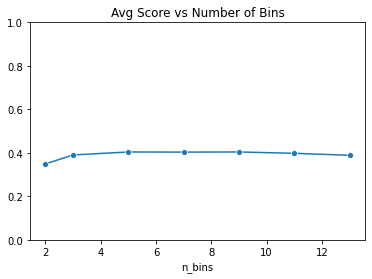

In [8]:
g = overall_results_df.groupby('n_bins')['Avg Score'].mean()

df = pd.DataFrame(g)
display(df)

s = sns.lineplot(x=g.index, y=g.values, marker='o')
s.set_ylim(0, 1.0)
s.set_title("Avg Score vs Number of Bins")
plt.show()

,Avg Score
max_dims,
2,0.405715
3,0.389063
4,0.387486
5,0.387380
6,0.387108


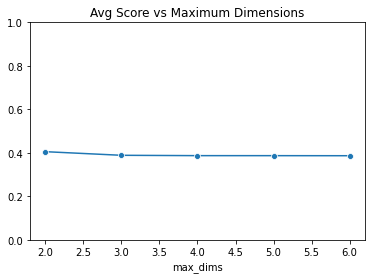

In [9]:
g = overall_results_df.groupby('max_dims')['Avg Score'].mean()

df = pd.DataFrame(g)
display(df)

s = sns.lineplot(x=g.index, y=g.values, marker='o')
s.set_ylim(0, 1.0)
s.set_title("Avg Score vs Maximum Dimensions")
plt.show()

,Avg Score
threshold,
0.01,0.213400
0.02,0.399160
0.05,0.487464
0.10,0.466653
0.25,0.390073


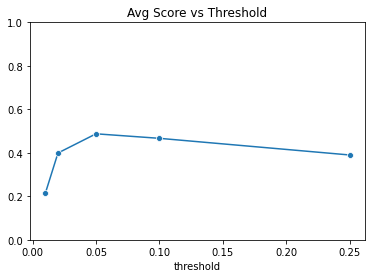

In [10]:
g = overall_results_df.groupby('threshold')['Avg Score'].mean()

df = pd.DataFrame(g)
display(df)

s = sns.lineplot(x=g.index, y=g.values, marker='o')
s.set_ylim(0, 1.0)
s.set_title("Avg Score vs Threshold")
plt.show()